In [1]:
#from seaborn import load_dataset
from julearn import run_cross_validation
from julearn import PipelineCreator
from julearn.utils import configure_logging
from sklearn.model_selection import StratifiedKFold
from julearn.viz import plot_scores
from junifer.storage import HDF5FeatureStorage
from nilearn import datasets, plotting
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np
import pandas as pd
import os                                                                   
import glob  

# Leyendo features de FC

Leemos todos los features de FC (para Schaefer100x17 y CogAr spheres) en un dataframe ordenados por $(sub_i, run_j, block_k)$ i=1...16, j=1...5, k=0...11, 

In [2]:
# Order files by (#sub, #run, #block)
def get_key(fp):
    filename = os.path.splitext(os.path.basename(fp))[0]
    split = filename.split("_")
    return (int(split[1]), int(split[2]), int(split[3]))

In [3]:
df_parcellation = None
df_spheres = None
df_reho_parcellation = None
df_reho_spheres = None
for file in (list(sorted(glob.glob('../Features/ds003548/*.hdf5'),key=get_key))):                                       
    storage = HDF5FeatureStorage(file)
    df = storage.read_df("BOLD_FC-Parcellation-Schaefer100x17")
    df_parcellation = pd.concat([df_parcellation, df])
    df = storage.read_df("BOLD_FC-CogAR-5mm")
    df_spheres = pd.concat([df_spheres, df])
    df = storage.read_df("BOLD_ReHO-Parcellation-Schaefer100x17")
    df_reho_parcellation = pd.concat([df_reho_parcellation, df])
    df = storage.read_df("BOLD_ReHo-CogAR-5mm")
    df_reho_spheres = pd.concat([df_reho_spheres, df])
    
assert(len(df_parcellation) == 960)
assert(len(df_spheres) == 960)
assert(len(df_reho_parcellation) == 960)
assert(len(df_reho_spheres) == 960)

## Matrices de correlación

In [4]:
# Veamos una muestra
fc = df_parcellation.iloc[6]
lower_corr = np.zeros((100,100))
lower_ix = np.tril_indices(100)
lower_corr[lower_ix] = fc
corr =  lower_corr.T + lower_corr - np.eye(100) 

assert(np.all(np.abs(corr) <= 1))
assert(np.allclose(corr, corr.T))

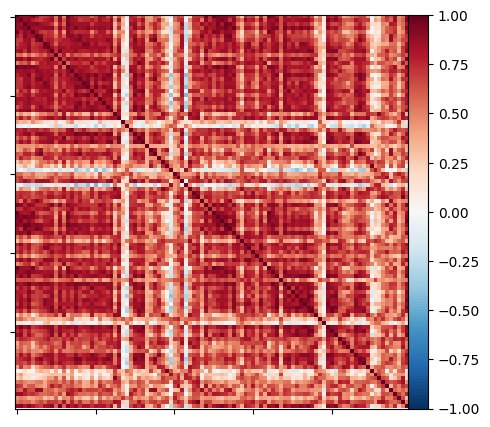

In [5]:
plotting.plot_matrix(
    corr,
    figure=(5, 5),
    vmax=1,
    vmin=-1,
    # title="Correlation",
    #tri="full"
)

In [6]:
def mean_corr(fc):
    lower_corr = np.zeros((100,100))
    lower_ix = np.tril_indices(100)
    lower_corr[lower_ix] = fc
    corr =  lower_corr.T + lower_corr - np.eye(100) 
    return np.mean(corr,0)

In [7]:
emos = ["happy", "sad", "angry", "neutral"]
df_trial_type = None
for nruns in range(1,6):
    _ = pd.read_csv(f"task-emotionalfaces_run-{nruns}_events.tsv", sep="\t")['trial_type'][:12]
    df_trial_type = pd.concat([df_trial_type, _])

In [8]:
# Mean correlation por columna de cada matriz 
final_df = pd.DataFrame(df_parcellation.apply(mean_corr, axis=1).to_list(), df_parcellation.index)

In [9]:
final_df["trial_type"] = pd.concat([df_trial_type] * 16).values
final_df

,,,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,trial_type
chunk,run,subject,,,,,,,,,,,,,,,,,,,,,
0,1,01,0.805637,0.742459,0.800107,0.756947,0.777265,0.790627,0.800010,0.778677,0.758724,0.735622,...,0.581773,0.698646,0.679934,0.778498,0.676690,0.502468,0.544747,0.284162,0.661454,blank
1,1,01,0.695597,0.492198,0.323115,0.763729,0.721321,0.777365,0.767389,0.730714,0.758989,0.742837,...,0.677021,0.675231,0.268822,0.672775,0.643774,0.724810,0.547726,0.734434,0.711471,scrambled
2,1,01,0.807571,0.873433,0.863720,0.894041,0.804360,0.847253,0.894678,0.848363,0.852467,0.890678,...,0.820503,0.870079,0.669474,0.683351,0.836463,0.793309,0.815804,0.881372,0.725533,happy
3,1,01,0.709055,0.647213,0.704391,0.714852,0.665874,0.738688,0.761605,0.649518,0.828183,0.774541,...,0.749037,0.768057,0.687213,0.670715,0.590293,0.327448,0.717126,0.806771,0.719049,sad
4,1,01,0.289317,0.326121,-0.110222,0.087359,0.190657,0.050230,-0.011600,0.419522,0.439362,0.440910,...,0.151434,0.279353,0.295505,0.363917,-0.195604,0.208860,0.143038,0.250995,0.352736,angry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,5,16,0.692497,0.595163,0.679699,0.653943,0.739896,0.636849,0.600353,0.649014,0.721299,0.681540,...,0.573322,0.704582,0.658065,0.684695,0.653741,0.498269,0.560212,0.611395,0.683542,sad
8,5,16,0.541736,0.485626,0.467248,0.518370,0.575570,0.525069,0.545549,0.551604,0.606905,0.515877,...,0.455003,0.552230,0.547517,0.407370,0.461952,0.317663,0.590468,0.579145,0.556214,happy
9,5,16,0.506758,0.487139,0.550462,0.563036,0.520572,0.535248,0.402543,0.520755,0.532656,0.459078,...,0.508386,0.569185,0.522582,0.356468,0.559874,0.483433,0.529328,0.501026,0.400143,neutral


In [10]:
df_spheres["trial_type"] = pd.concat([df_trial_type] * 16).values
df_reho_parcellation["trial_type"] = pd.concat([df_trial_type] * 16).values
df_reho_spheres["trial_type"] = pd.concat([df_trial_type] * 16).values

# ML Pipeline


In [1]:
def apply_binary_mask_and_set_labels(df,emotions):
    mask = (df["trial_type"] == emotions[0]) | (df["trial_type"] == emotions[1])
    masked_df = df[mask].copy()
    idx_dict = {emo:i for i,emo in enumerate(emotions)}
    masked_df["trial_type"] = masked_df["trial_type"].map(idx_dict)
    masked_df.columns = masked_df.columns.astype(str)
    return masked_df.rename_axis(['chunk', 'run', 'subject']).reset_index(), list(masked_df.columns[:-1]), "trial_type"

def apply_one_vs_all_mask_and_set_labels(df,emotion):
    mask = (df["trial_type"] == emotion) | (df["trial_type"] != emotion)
    masked_df = df[mask].copy()
    masked_df["trial_type"] = masked_df["trial_type"].map({emotion:1}).fillna(0)
    masked_df.columns = masked_df.columns.astype(str)
    return masked_df.rename_axis(['chunk', 'run', 'subject']).reset_index(), list(masked_df.columns[:-1]), "trial_type"


In [11]:
# create a dict of pairs of emotions based on the emos list i.e (happy, sad), (happy, anger)...
binary_data = {(emos[i], emos[j]):{} for i in range(len(emos)) for j in range(i+1, len(emos))}

# create a dict of emotions based on the emos list (for one vs all problem)
one_vs_all_data = {emo:{} for emo in emos}

# ML Pipeline #

# Features to use
features_list = {"parcellation":final_df, "spheres":df_spheres, "reho_parcellation":df_reho_parcellation, "reho_spheres":df_reho_spheres}

# Models: SVM and RandomForest
# non-linear SVM
creator1 = PipelineCreator(problem_type="classification")
creator1.add("zscore")
creator1.add("svm", kernel=["rbf", "sigmoid"], gamma=np.logspace(-1,3,3), C=[.001,.01,0.1,1,10,100])

# linear SVM
creator2 = PipelineCreator(problem_type="classification")
creator2.add("zscore")
creator2.add("svm", kernel=["linear"], C=[.001,.01,0.1,1,10,100])

# Random Forest
creator3 = PipelineCreator(problem_type="classification")
creator3.add("zscore")
creator3.add("rf", n_estimators=[10,20,30,40,50,100],max_depth=[3,4,5,6], random_state=[42, 1337, 95])

# Dummy
creator4 = PipelineCreator(problem_type="classification")
creator4.add("zscore")
creator4.add("dummy")

# 3 ways of doing Kfold CV:
# Stratified
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)

# Grouped stratified (by subject or by run)
cv_stratified_group = StratifiedGroupKFold(n_splits=5, shuffle=True,random_state=42)
cv_and_groups = {"no_groups":(cv_stratified, None), "subjects":(cv_stratified_group, "subject"), "runs":(cv_stratified_group, "run")}


## Model selection (binary one vs one subproblems)

For each binary subproblem, feature type and CV type we run the ML pipeline defined previously

In [ ]:
# For each 
# Train models and store results
for pair in binary_data.keys():
    binary_data[pair]= {}
    for feature_type in features_list.keys():
        binary_data[pair][feature_type] = {}
        for grouping in cv_and_groups.keys():
            binary_df, features, target = apply_binary_mask_and_set_labels(features_list[feature_type], pair)
            binary_data[pair][feature_type][grouping] = {}
            binary_data[pair][feature_type][grouping]["SVM"] = {}
            binary_data[pair][feature_type][grouping]["Random Forest"] = {}
            binary_data[pair][feature_type][grouping]["Dummy"] = {}
            # SVM CV
            scores, model, inspector = run_cross_validation(
            X = features,
            y = target,
            data = binary_df,
            model = [creator1, creator2],
            cv = cv_and_groups[grouping][0],
            groups=cv_and_groups[grouping][1],
            return_train_score=True,
            return_inspector=True,
            n_jobs=-1
            )

            # Store scores
            scores["model"] = "SVM"
            binary_data[pair][feature_type][grouping]["SVM"]["scores"] = scores
            binary_data[pair][feature_type][grouping]["SVM"]["model"] = model
            binary_data[pair][feature_type][grouping]["SVM"]["inspector"] = inspector

            # Random Forest CV
            scores, model, inspector = run_cross_validation(
            X = features,
            y = target,
            data = binary_df,
            model = creator3,
            cv = cv_and_groups[grouping][0],
            groups=cv_and_groups[grouping][1],
            return_train_score=True,
            return_inspector=True,
            n_jobs = -1
            )
            # Store scores
            scores["model"] = "Random Forest"
            binary_data[pair][feature_type][grouping]["Random Forest"]["scores"] = scores
            binary_data[pair][feature_type][grouping]["Random Forest"]["model"] = model
            binary_data[pair][feature_type][grouping]["Random Forest"]["inspector"] = inspector

            # Dummy
            scores, model, inspector = run_cross_validation(
            X = features,
            y = target,
            data = binary_df,
            model = creator4,
            cv = cv_and_groups[grouping][0],
            groups=cv_and_groups[grouping][1],
            return_train_score=True,
            return_inspector=True,
            n_jobs=-1
            )

            # Store scores
            scores["model"] = "Dummy"
            binary_data[pair][feature_type][grouping]["Dummy"]["scores"] = scores
            binary_data[pair][feature_type][grouping]["Dummy"]["model"] = model
            binary_data[pair][feature_type][grouping]["Dummy"]["inspector"] = inspector

/home/nicolas/.pyenv/versions/3.8.10/envs/asterix/lib/python3.8/site-packages/panel/viewable.py:298: ParamFutureWarning: Parameter 'object' on <class 'panel.pane.base.PaneBase'> is being given a valid parameter reference <bound method _JulearnScoresViewer.plot_scores of _JulearnScoresViewer(group_repeats='no', metric='score', models=['SVM', 'Random Forest', 'Dummy'], name='_JulearnScoresViewer00118', sets=['test', 'train'], show_stats=False)> but is implicitly allow_refs=False. In future allow_refs will be enabled by default and the reference <bound method _JulearnScoresViewer.plot_scores of _JulearnScoresViewer(group_repeats='no', metric='score', models=['SVM', 'Random Forest', 'Dummy'], name='_JulearnScoresViewer00118', sets=['test', 'train'], show_stats=False)> will be resolved to its underlying value figure(id='0277b1bb-98e4-4f28-b5fc-b43c6a8a39c6', ...). Please explicitly set allow_ref on the Parameter definition to declare whether references should be resolved or not.
  super()._

Column
    [0] Row
        [0] PNG(str, width=200)
        [1] Spacer(width=50)
        [2] Markdown(str)
    [1] Row
        [0] Param(_JulearnScoresViewer, name='Metric', parameters=['metric'], widgets={'metric': {'type': <class...})
        [1] Param(_JulearnScoresViewer, name='Statistics', parameters=['show_stats'], widgets={'show_stats': {'type': <c...})
        [2] Param(_JulearnScoresViewer, name='Aggregate Repeats', parameters=['group_repeats'], widgets={'group_repeats': {'type':...})
    [2] Row
        [0] ParamMethod(method, _pane=Bokeh, defer_load=False)
        [1] Column
            [0] Param(_JulearnScoresViewer, name='Sets', parameters=['sets'], widgets={'sets': {'type': <class '...})
            [1] Param(_JulearnScoresViewer, name='Models', parameters=['models'], widgets={'models': {'type': <class...})
    [3] ParamMethod(method, _pane=Markdown, defer_load=False)
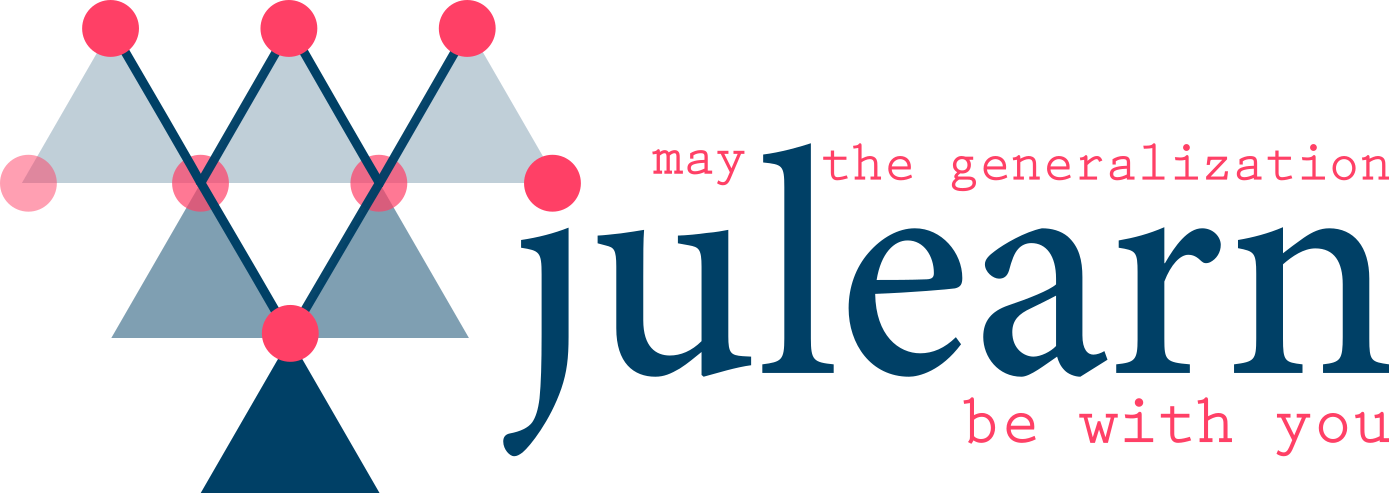

In [13]:
plot_scores(binary_data[("happy","sad")]["reho_parcellation"]["no_groups"]["SVM"]["scores"], 
            binary_data[("happy","sad")]["reho_parcellation"]["no_groups"]["Random Forest"]["scores"],
            binary_data[("happy","sad")]["reho_parcellation"]["no_groups"]["Dummy"]["scores"])

In [37]:
#scores = []
#for k1 in binary_data.keys():
#    for k2 in binary_data[k1].keys():
#        for k3 in binary_data[k1][k2].keys():
#            scores.append(binary_data[k1][k2][k3]["SVM"]["scores"])
#            scores.append(binary_data[k1][k2][k3]["Random Forest"]["scores"])
#            scores.append(binary_data[k1][k2][k3]["Dummy"]["scores"])
#            

# Model selection (one vs all)
For each binary one vs all subproblem, feature type and CV type we run the ML pipeline defined previously

In [ ]:
for emotion in one_vs_all_data.keys():
    one_vs_all_data[emotion] = {}
    for feature_type in features_list.keys():
        one_vs_all_data[emotion][feature_type] = {}
        for grouping in cv_and_groups.keys():
            one_vs_all_df, features, target = apply_one_vs_all_mask_and_set_labels(features_list[feature_type], emotion)
            one_vs_all_data[emotion][feature_type][grouping] = {}
            one_vs_all_data[emotion][feature_type][grouping]["SVM"] = {}
            one_vs_all_data[emotion][feature_type][grouping]["Random Forest"] = {}
            one_vs_all_data[emotion][feature_type][grouping]["Dummy"] = {}
            # SVM
            scores, model, inspector = run_cross_validation(
            X = features,
            y = target,
            data = one_vs_all_df,
            model = [creator1, creator2],
            cv = cv_and_groups[grouping][0],
            groups=cv_and_groups[grouping][1],
            return_train_score=True,
            return_inspector=True,
            scoring=["balanced_accuracy","accuracy","f1"],
            n_jobs=-1
            )

            scores["model"] = "SVM"
            one_vs_all_data[emotion][feature_type][grouping]["SVM"]["scores"] = scores
            one_vs_all_data[emotion][feature_type][grouping]["SVM"]["model"] = model
            one_vs_all_data[emotion][feature_type][grouping]["SVM"]["inspector"] = inspector

            # Random Forest
            scores, model, inspector = run_cross_validation(
            X = features,
            y = target,
            data = one_vs_all_df,
            model = creator3,
            cv = cv_and_groups[grouping][0],
            groups=cv_and_groups[grouping][1],
            return_train_score=True,
            return_inspector=True,
            scoring=["balanced_accuracy","accuracy","f1"],
            n_jobs = -1
            )

            scores["model"] = "Random Forest"
            one_vs_all_data[emotion][feature_type][grouping]["Random Forest"]["scores"] = scores
            one_vs_all_data[emotion][feature_type][grouping]["Random Forest"]["model"] = model
            one_vs_all_data[emotion][feature_type][grouping]["Random Forest"]["inspector"] = inspector

            # Dummy
            scores, model, inspector = run_cross_validation(
            X = features,
            y = target,
            data = one_vs_all_df,
            model = creator4,
            cv = cv_and_groups[grouping][0],
            groups=cv_and_groups[grouping][1],
            return_train_score=True,
            return_inspector=True,
            scoring=["balanced_accuracy","accuracy","f1"],
            n_jobs=-1
            )

            scores["model"] = "Dummy"
            one_vs_all_data[emotion][feature_type][grouping]["Dummy"]["scores"] = scores
            one_vs_all_data[emotion][feature_type][grouping]["Dummy"]["model"] = model
            one_vs_all_data[emotion][feature_type][grouping]["Dummy"]["inspector"] = inspector


# Pickle results

In [46]:
with open('one_vs_all.pickle', 'wb') as handle:
    pickle.dump(one_vs_all_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [47]:
with open('binary_data.pickle', 'wb') as handle:
    pickle.dump(binary_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [54]:
with open('one_vs_all.pickle', 'rb') as handle:
    b = pickle.load(handle)